In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [54]:
ad_path = [
 'hour4_imputed.h5ad',
 'hour12_imputed.h5ad',
 'day2_imputed.h5ad',
 'week6_imputed.h5ad',
 'sham_imputed.h5ad',
 'day14_imputed.h5ad']

ad_list = dict()
for file in ad_path:
    ident = file.split('_')[0]
    print(ident)
    adata = sc.read_h5ad(os.path.join("impuation_h5ad", file))
    ad_list[ident] = adata

hour4
hour12
day2
week6
sham
day14


In [55]:
imputed_all = anndata.concat(ad_list,join = "outer")

In [115]:
select_pairs = ['Col4a3-Cd44','Lamb1-Itgav','Col4a3-Itga1','Spp1-Itgb1','Col4a5-Itgav','Col4a1-Cd44','Itga4-Vcam1','Ccl2-Ccr2','Icam1-Itgam','Icam1-Itgb2','Icam1-Itgal','C3-Itgam','Csf1-Csf1r','Il34-Csf1r','Tgfb2-Tgfbr2','Tgfb2-Tgfbr1','Sema3c-Nrp2','Sema3c-Nrp1','Pdgfa-Pdgfrb','Pdgfb-Pdgfrb',
                'Pdgfd-Pdgfrb','Fn1-Itgb6','Tnc-Itgb6','Col4a1-Itgav','Lama2-Itga1','Lama2-Itgav','Fn1-Cd44','Spp1-Cd44','Col1a2-Cd44','Lama2-Itgb8','Tnc-Itga9','Col1a2-Itga9','Col4a2-Itga9','Col4a1-Itga9']

In [116]:
select_pairs.reverse()

In [117]:
imputed_all.obs.celltype_plot.cat.categories

Index(['Pod', 'Glom-EC', 'PTS1', 'PTS2', 'PTS3', 'Inj_PT', 'FR_PT', 'DTL',
       'TAL', 'DCT', 'CNT', 'PC', 'ICA', 'ICB', 'Uro', 'PEC', 'EC', 'Fib',
       'Per-SMC', 'Immune'],
      dtype='object')

In [127]:
co_exp_list =[]
times = ['sham', 'hour4', 'hour12', 'day2', 'day14','week6']

for t in times:
    ad = ad_list[t].copy()
    ad = ad[ad.obs['celltype_plot'].isin(['Inj_PT', 'FR_PT','Fib','Immune'])]
    print(len(ad))
    for idx, pair in enumerate(select_pairs):
        if len(ad) < 500:
            co_exp_list.append({'time': t, 'ligand': ligand, 'receptor':receptor, 'lr_pair':lr_pair, 'co_expr_mean': 0})  
        else:
            ligand = pair.split('-')[0]
            receptor = pair.split('-')[1]
            lr_pair = f"{ligand}-{receptor}"
            if (ligand in ad.var.index) & (receptor in ad.var.index):
                lig_gene_id = np.where(ad.var.index == ligand)[0][0]
                rec_gene_id = np.where(ad.var.index == receptor)[0][0]
                
                lig_exp = ad.X[:, lig_gene_id].A.flatten()
                rec_exp = ad.X[:, rec_gene_id].A.flatten()
        
                co_expr = np.sum(np.log2(lig_exp * rec_exp+1))
                co_exp_list.append({'time': t, 'ligand': ligand, 'receptor':receptor, 'lr_pair':lr_pair, 'co_expr_mean': co_expr})
            else:
                co_exp_list.append({'time': t, 'ligand': ligand, 'receptor':receptor, 'lr_pair':lr_pair, 'co_expr_mean': 0})  

8641
27680
47759
41594
45203
25219


In [128]:
def normalize_group(x):
    min_val = x.min()
    max_val = x.max()
    if max_val - min_val == 0:
        return x * 0  # All values are the same; set normalized values to 0
    else:
        return (x - min_val) / (max_val - min_val)

In [129]:
co_expr_df = pd.DataFrame(co_exp_list)
co_expr_df['co_expr_norm'] = co_expr_df.groupby('lr_pair')['co_expr_mean'].transform(normalize_group)
heat_df = co_expr_df.pivot(index='lr_pair', columns='time', values='co_expr_norm')
heat_df = heat_df[times]
heat_df = heat_df.loc[select_pairs]

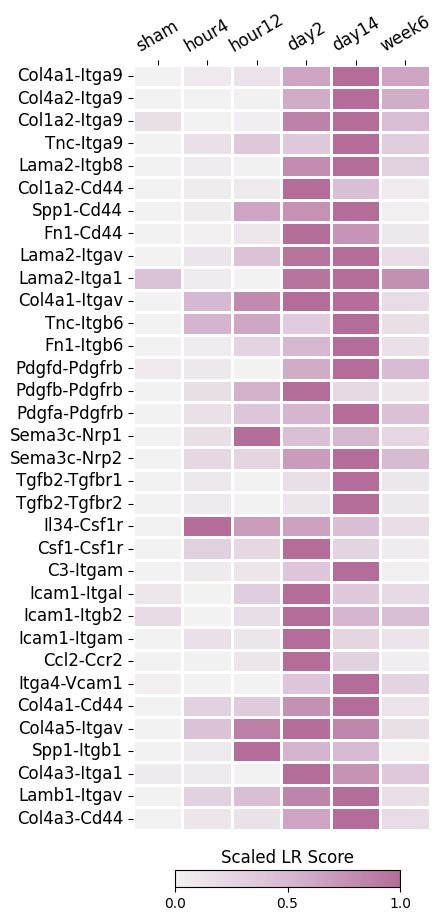

In [130]:
import matplotlib as mpl
cmap = mcolors.LinearSegmentedColormap.from_list('WhBu',["#f2f2f2", "#d7bad2", '#b36d98'], N=256) 
fig, ax = plt.subplots(figsize=(4.5,8.5), dpi=100)
cbar_ax = fig.add_axes([.4, -0.05, 0.5, 0.02])
colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=cmap), 
                        cax=cbar_ax,  #FCBF49
                        orientation='horizontal', 
                        ticks=[0, 0.5, 1])
colorbar.set_label('Scaled LR Score', labelpad=-45, size = "large")

sns.heatmap(heat_df, cmap=cmap, annot=False,linecolor='white',linewidths=1, cbar=False, ax=ax)
ax.xaxis.set_ticks_position('top')  
ax.xaxis.set_label_position('top') 
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha = 'center')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
#plt.savefig('timecourse_lr.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()